## 0. 라이브러리 / 기본셋업

In [67]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 32.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 26.6 MB/s eta 0:00:00


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno

버전 확인

- `python` >= 3.10.12
- `numpy` >= 1.26.0
- `pandas` >= 2.1.1
- `matplotlib` >= 3.8.1
- `seaborn` >= 0.13.0
- `missingno` >= 0.5.2

In [2]:
import sys, matplotlib

print("="*5 ,"나의 라이브러리 버전 확인", "="*5)
print(f"{'python version':15s} <> {sys.version}")
print(f"{'numpy version':15s} <> {np.__version__}")
print(f"{'pandas version':15s} <> {pd.__version__}")
print(f"{'matplotlib version':15s} <> {matplotlib.__version__}")
print(f"{'seaborn version':15s} <> {sns.__version__}")
print(f"{'missingno version':15s} <> {msno.__version__}")

===== 나의 라이브러리 버전 확인 =====
python version  <> 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
numpy version   <> 1.26.0
pandas version  <> 2.1.1
matplotlib version <> 3.8.1
seaborn version <> 0.13.0
missingno version <> 0.5.2


In [3]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# 데이터 경로 맞춰주세요!
# 혹시 코랩환경을 사용하신다면 왼쪽 폴더모양 아이콘을 눌러 "train_data.csv"를 드래그&드롭으로 업로드한 후 사용해주세요
DATA_PATH = '../data/train_data.csv'
df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

CPU times: user 4.05 s, sys: 587 ms, total: 4.64 s
Wall time: 4.69 s


## 1.1 기본적인 내용 파악

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266586 entries, 0 to 2266585
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   userID            int16         
 1   assessmentItemID  object        
 2   testId            object        
 3   answerCode        int8          
 4   Timestamp         datetime64[ns]
 5   KnowledgeTag      int16         
dtypes: datetime64[ns](1), int16(2), int8(1), object(2)
memory usage: 62.7+ MB


In [5]:
total_rows = df.shape[0]
print(total_rows)

2266586


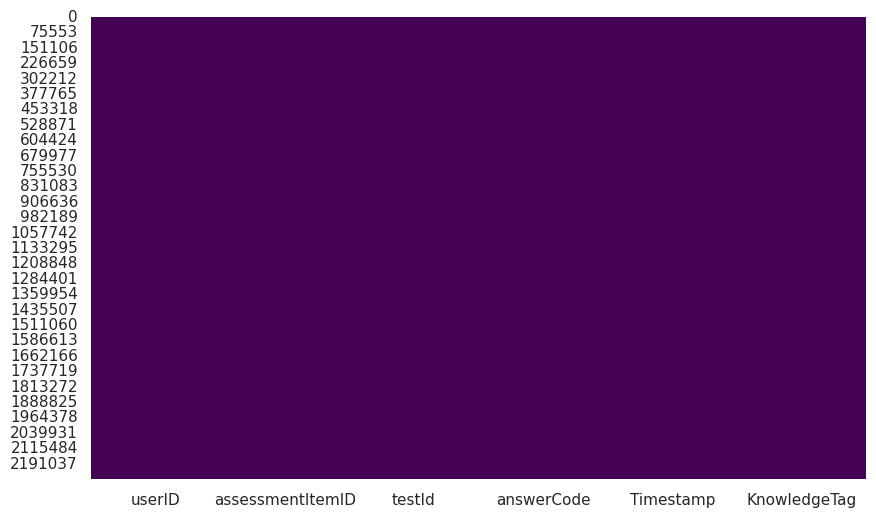

In [6]:
# 결측치 확인하기 위한 히트맵
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

## 데이터 딕셔너리

| 순번 |      칼럼명      | Non-Null 개수 |     데이터 타입       | 설명 |
|-----|-----------------|--------------|-----------------------|----------------|
|  1  |      userID      |      2266586    | int16                 | 각 학생의 고유 식별자 (총 7,442명의 학생) |
|  2  | assessmentItemID |      2266586    | object                | 사용자가 시도한 문항의 일련 번호 |
|  3  |      testId       |      2266586    | object                | 시도한 문항이 포함된 시험지의 일련 번호 |
|  4  |    answerCode    |      2266586    | int8                  | 사용자가 문항에 대한 정답 여부를 나타내는 이진 데이터 (1: 정답, 0: 오답) |
|  5  |    Timestamp      |      2266586    | datetime64[ns]        | 사용자가 문항을 시도한 시간 정보 |
|  6  |   KnowledgeTag    |      2266586    | int16                 | 문항의 지식 태그 (고유 식별자) |
|  7  |     elapsed       |      2266586    | float64               | 문항을 완료하는 데 걸린 시간 (해당되는 경우) |



### 특성의 기본 정보

In [7]:
print(f"""--- BASIC INFORMATIONS ---
userID           : {df.userID.nunique()}
assessmentItemID : {df.assessmentItemID.nunique()}
testID           : {df.testId.nunique()}
mean answer rate : {df.answerCode.sum() / df.shape[0] * 100:.2f}%
KnowledgeTag     : {df.KnowledgeTag.nunique()}
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID           : 6698
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.44%
KnowledgeTag     : 912
--------------------------


### 일련 번호 분석

#### 첫 번째 단어 A
A 밖에 없는 것을 확인할 수 있음

In [8]:
df['assessmentItemID'].apply(lambda x: x[0]).unique()

array(['A'], dtype=object)

#### 문항 일련 번호 내 시험지 번호
문항 일련 번호의 1-6번째 자리와 시험지 번호의 1-3번째+마지막3자리 합이 같은지 확인합니다.   
전체 데이터 개수와 일치함을 알 수 있습니다.

In [9]:
sum(df['assessmentItemID'].apply(
    lambda x: x[1:7]) == df['testId'].apply(lambda x: x[1:4]+x[7:])
)

2266586

#### 시험지 번호 가운데 3자리 모두 000

In [10]:
df['testId'].apply(lambda x: x[4:7]).unique()

array(['000'], dtype=object)

## 1.2 기술 통계량 분석

In [11]:
def percentile(s):
    return np.sum(s) / len(s)

In [12]:
tag_groupby = df.groupby('KnowledgeTag').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})

In [13]:
tag_groupby

,assessmentItemID,answerCode
KnowledgeTag,,
23,1800,0.584444
24,358,0.614525
25,92,0.858696
26,2432,0.614309
30,539,0.536178
...,...,...
11253,4282,0.739374
11265,454,0.676211
11269,2417,0.557716


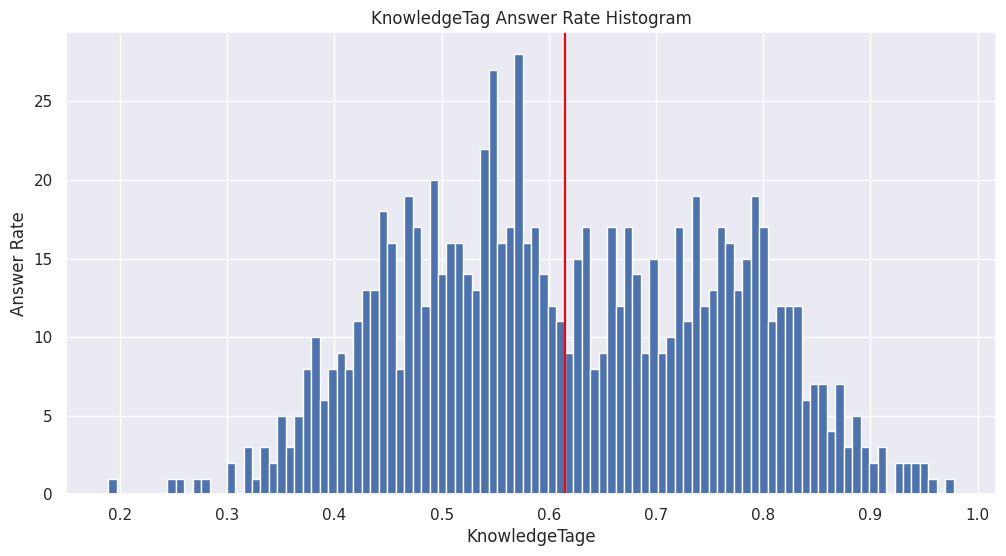

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))


tag_groupby['answerCode'].hist(bins=100, ax=ax)

ax.set_title('KnowledgeTag Answer Rate Histogram')
ax.set_xlabel('KnowledgeTage')
ax.set_ylabel('Answer Rate')
ax.axvline(tag_groupby['answerCode'].mean(), color='red')
ax.grid(visible=True)

In [15]:
tag_df = tag_groupby.reset_index()
tag_df
tag_df['KnowledgeTagBin'] = pd.cut(tag_df.index, bins=100)
tag_df

,KnowledgeTag,assessmentItemID,answerCode,KnowledgeTagBin
0,23,1800,0.584444,"(-0.911, 9.11]"
1,24,358,0.614525,"(-0.911, 9.11]"
2,25,92,0.858696,"(-0.911, 9.11]"
3,26,2432,0.614309,"(-0.911, 9.11]"
4,30,539,0.536178,"(-0.911, 9.11]"
...,...,...,...,...
907,11253,4282,0.739374,"(901.89, 911.0]"
908,11265,454,0.676211,"(901.89, 911.0]"
909,11269,2417,0.557716,"(901.89, 911.0]"
910,11270,261,0.478927,"(901.89, 911.0]"


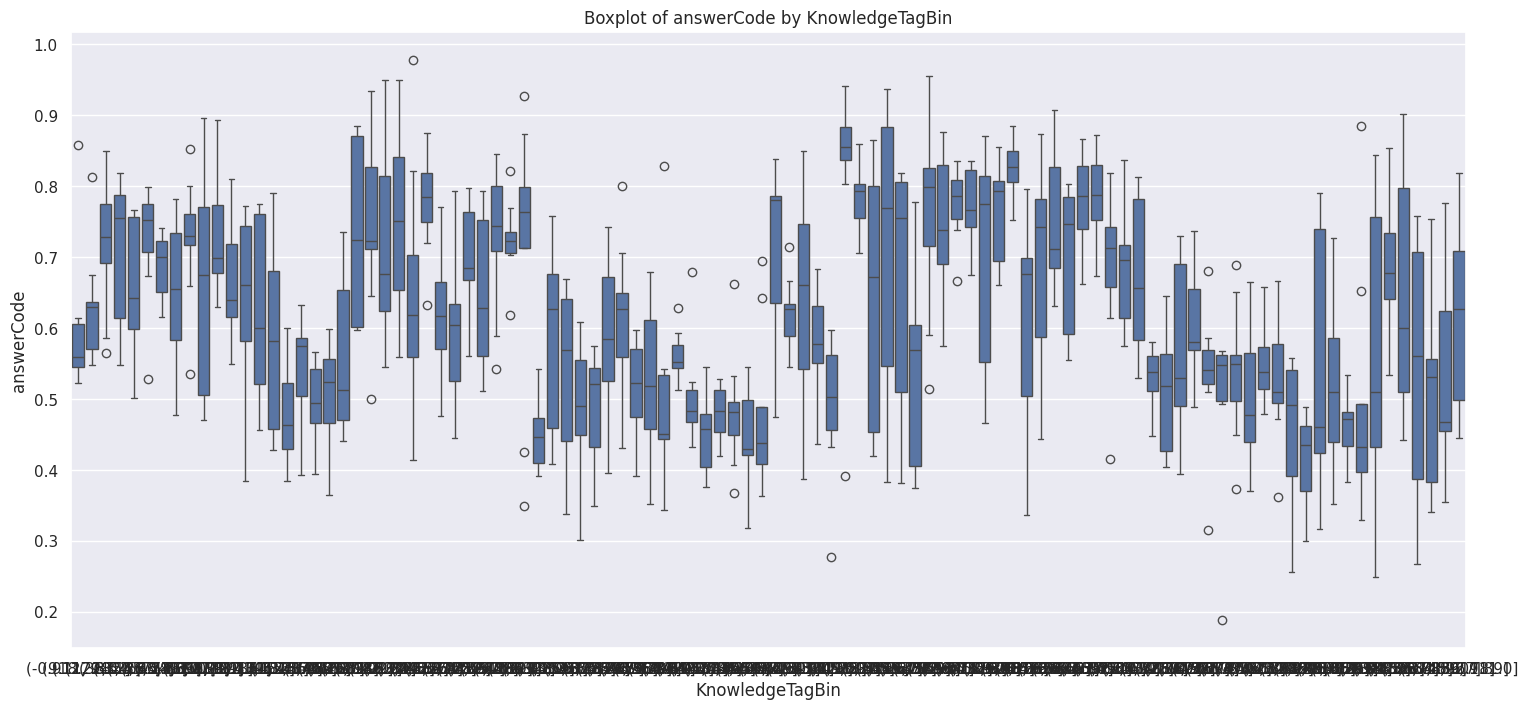

In [20]:
plt.figure(figsize=(18, 8))
sns.boxplot(x='KnowledgeTagBin', y='answerCode', data=tag_df)

plt.title('Boxplot of answerCode by KnowledgeTagBin')
plt.show()

In [21]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

alpha = 0.05
model = ols('answerCode ~ C(KnowledgeTagBin)', tag_df).fit()
display(anova_lm(model))
print('\n')

if anova_lm(model).loc['C(KnowledgeTagBin)', 'PR(>F)'] >= alpha:
  print(f'p-value가 유의수준(alpha) {alpha} 보다 높으므로 귀무가설을 채택하고 대립가설을 기각합니다.')
else:
  print(f'p-value가 유의수준(alpha) {alpha} 보다 낮으므로 귀무가설을 기각하고 대립가설을 채택합니다.')

,df,sum_sq,mean_sq,F,PR(>F)
C(KnowledgeTagBin),99.0,9.849816,0.099493,7.925345,4.836463e-69
Residual,812.0,10.193676,0.012554,NaN,NaN




p-value가 유의수준(alpha) 0.05 보다 낮으므로 귀무가설을 기각하고 대립가설을 채택합니다.


### 사용자 분석
`groupby` 함수는 정형 데이터의 집계/요약을 하는 데 있어 굉장히 중요한 분석 도구입니다. 가장 기본적인 사용문법은 -
+ `(데이터프레임).groupby(분리할KEY).agg({합치고싶은특성: 어떻게합칠지, ...})`
로 사용하면 됩니다! 라고 하기엔 이렇게만 보면 `groupby`는 이해가 어렵습니다.


가령 사용자별로 몇 개의 문제를 풀었는지 보고싶다고 하면,    
`df.groupby("userID").agg({"assessmentItemID": "count"})`   
라고 사용하면, `userID`의 개개인 고유값에 대해 `assessmentItemID`값을 모두 가져와서 몇 개 있는지 세주고 싶으면 `count` 해줍니다. 일반적으로 이렇게 문자열을 넣어주면 `pandas` 라이브러리 내에 미리 만들어진 집계함수를 사용할 수 있습니다. 자세한 사용법은 공식 Documentation을 참고.

In [46]:
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_groupby.describe()

,assessmentItemID,answerCode
count,6698.000000,6698.000000
mean,338.397432,0.628909
std,321.331429,0.159639
min,9.000000,0.000000
25%,78.000000,0.527273
50%,231.500000,0.651757
75%,513.000000,0.751203
max,1860.000000,1.000000


#### 사용자 문항 개수 도수분포표

In [47]:
stu_groupby

,assessmentItemID,answerCode
userID,,
0,745,0.630872
1,933,0.853162
2,276,0.612319
5,833,0.795918
6,921,0.442997
...,...,...
7436,15,0.466667
7437,16,0.375000
7438,16,0.750000


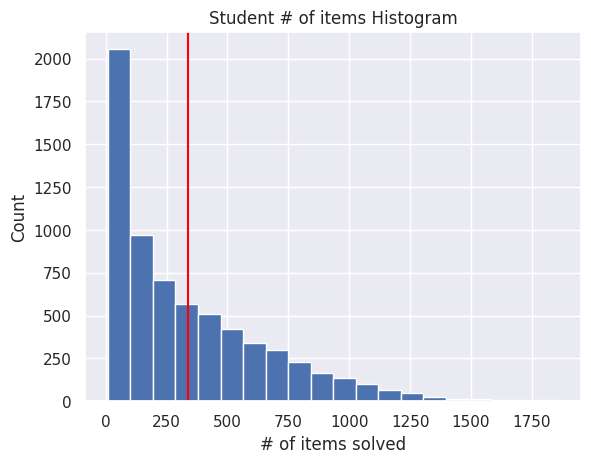

In [13]:
fig, ax = plt.subplots()

stu_groupby['assessmentItemID'].hist(bins=20, ax=ax)

ax.set_title('Student # of items Histogram')
ax.set_xlabel('# of items solved')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['assessmentItemID'].mean(), color='red')
ax.grid(visible=True)

#### 사용자 정답률 도수분포표

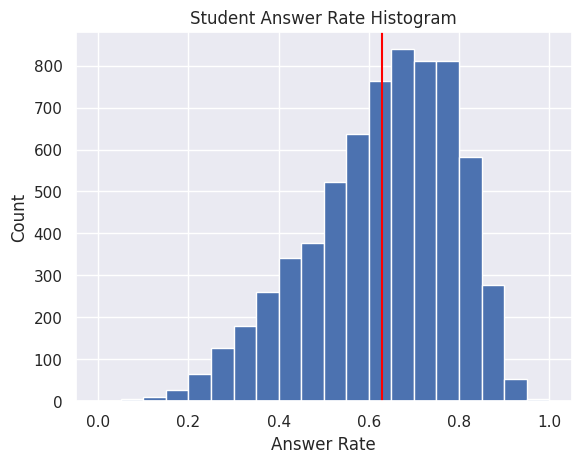

In [14]:
fig, ax = plt.subplots()

stu_groupby['answerCode'].hist(bins=20)

ax.set_title('Student Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['answerCode'].mean(), color='red')
ax.grid(visible=True)

### 문항 별 정답률 분석

In [15]:
prob_groupby = df.groupby('assessmentItemID').agg({
    'userID': 'count',
    'answerCode': percentile
})
prob_groupby.describe()

,userID,answerCode
count,9454.000000,9454.000000
mean,239.748889,0.654256
std,71.893791,0.195488
min,43.000000,0.049430
25%,220.000000,0.505548
50%,230.000000,0.666667
75%,271.000000,0.820513
max,454.000000,0.996310


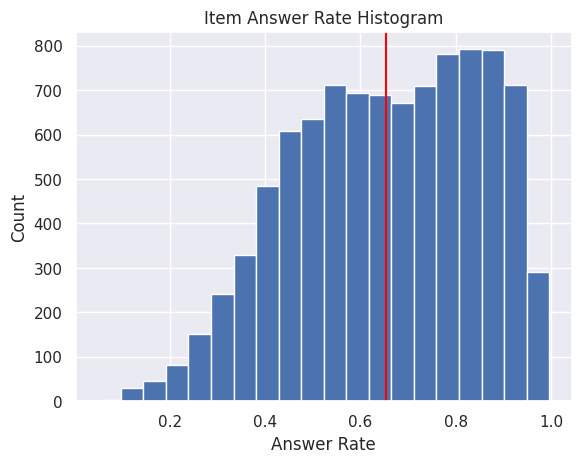

In [16]:
fig, ax = plt.subplots()
prob_groupby['answerCode'].hist(bins=20)
ax.set_title('Item Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(prob_groupby['answerCode'].mean(), color='red')
ax.grid(visible=True)

### 시험지 별 정답률 분석

In [17]:
test_groupby = df.groupby('testId').agg({
    'userID': 'count',
    'answerCode': percentile
})
test_groupby.describe()

,userID,answerCode
count,1537.000000,1537.000000
mean,1474.681848,0.667982
std,533.526783,0.138903
min,172.000000,0.327186
25%,1320.000000,0.561819
50%,1400.000000,0.680519
75%,1602.000000,0.778439
max,3960.000000,0.955474


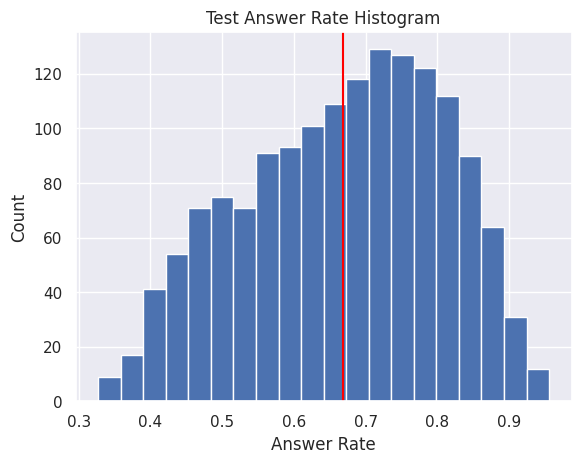

In [18]:
fig, ax = plt.subplots()
test_groupby['answerCode'].hist(bins=20)
ax.set_title('Test Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(test_groupby['answerCode'].mean(), color='red')
ax.grid(visible=True)

## 1.3 일반적인 EDA

### 문항을 더 많이 푼 학생이 문제를 더 맞추는가?
분포도 위에 전반적인 동향을 살피고 싶을 때 `seaborn` 라이브러리의 `lmplot`을 사용하면 좋습니다.

Text(0.5, 1.0, '# of Questions - Answer Rate')

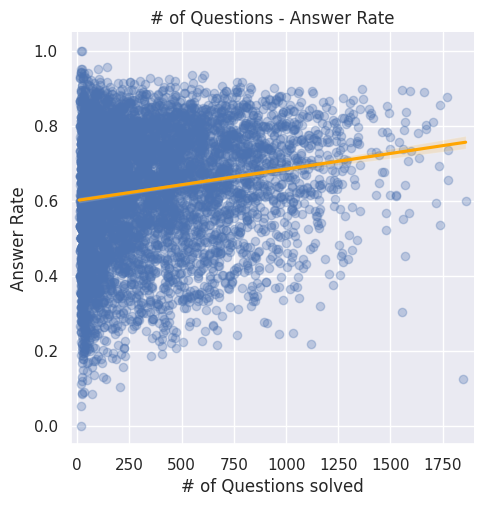

In [19]:
g = sns.lmplot(
    data=stu_groupby,
    x='assessmentItemID',
    y='answerCode',
    scatter_kws={'alpha':0.3},
    line_kws={"color": "orange"}
)
g.set_xlabels('# of Questions solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 1900))

ax = plt.gca()
ax.set_title('# of Questions - Answer Rate')

In [20]:
# 상관관계는 특성 간 인과를 알려주지 않지만 어느 정도 살펴보기는 해야하는 지표입니다.
print(f"정답률과 문제를 푼 개수 사이 상관관계: {stu_groupby.corr()['assessmentItemID']['answerCode']:.3f}")

정답률과 문제를 푼 개수 사이 상관관계: 0.168


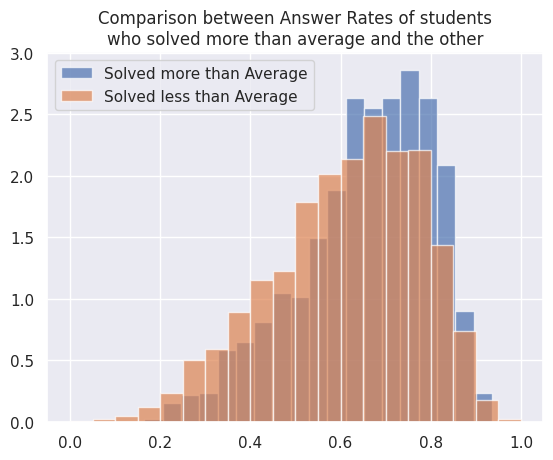

In [21]:
fig, ax = plt.subplots()

ax.set_title('Comparison between Answer Rates of students\nwho solved more than average and the other')
stu_num_mean = stu_groupby['assessmentItemID'].mean()
stu_groupby[stu_groupby['assessmentItemID'] >= stu_num_mean]['answerCode'].hist(
    bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Solved more than Average'
)
stu_groupby[stu_groupby['assessmentItemID'] < stu_num_mean]['answerCode'].hist(
    bins=20, ax=ax, alpha=0.7, stacked=True, density=1, label='Solved less than Average'
)
ax.legend()

### 더 많이 노출된 태그가 정답률이 더 높은가?

In [22]:
tag_groupby = df.groupby('KnowledgeTag').agg({
    'userID': 'count',
    'answerCode': percentile
})
tag_groupby.describe()

,userID,answerCode
count,912.000000,912.000000
mean,2485.291667,0.615524
std,1732.086925,0.148329
min,44.000000,0.188940
25%,1025.250000,0.498239
50%,2204.000000,0.599585
75%,4052.750000,0.740288
max,12892.000000,0.977778


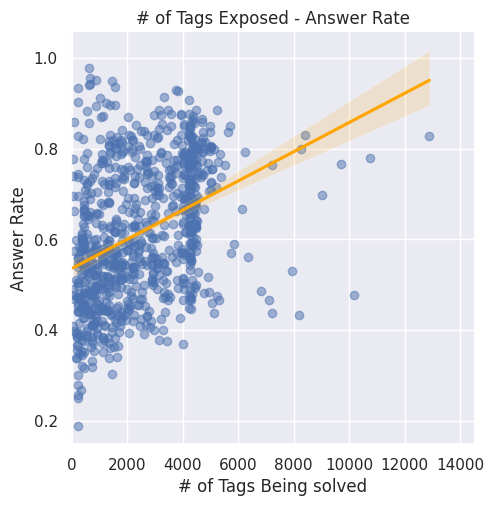

In [23]:
g = sns.lmplot(
    data=tag_groupby,
    x='userID',
    y='answerCode',
    scatter_kws={'alpha':0.5},
    line_kws={"color": "orange"}
)
g.set_xlabels('# of Tags Being solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 14500))

ax = plt.gca()
ax.set_title('# of Tags Exposed - Answer Rate');

In [24]:
tag_groupby

,userID,answerCode
KnowledgeTag,,
23,1800,0.584444
24,358,0.614525
25,92,0.858696
26,2432,0.614309
30,539,0.536178
...,...,...
11253,4282,0.739374
11265,454,0.676211
11269,2417,0.557716


In [25]:
print(f"태그를 풀었던 사용자의 수와 정답률 사이 상관관계: {tag_groupby.corr()['answerCode']['userID']:.3f}")

태그를 풀었던 사용자의 수와 정답률 사이 상관관계: 0.376


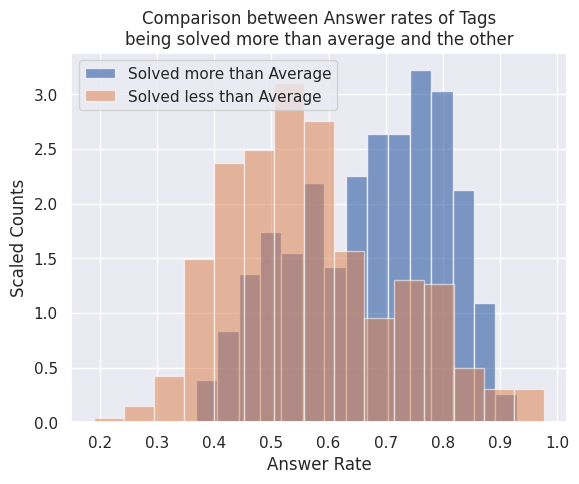

In [26]:
fig, ax = plt.subplots()

tag_ans_mean = tag_groupby['userID'].mean()
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Scaled Counts')
ax.set_title('Comparison between Answer rates of Tags\nbeing solved more than average and the other')

tag_groupby[tag_groupby['userID'] >= tag_ans_mean]['answerCode'].hist(
    ax=ax, alpha=0.7, bins=15, density=1, stacked=True, label='Solved more than Average'
)
tag_groupby[tag_groupby['userID'] < tag_ans_mean]['answerCode'].hist(
    ax=ax, alpha=0.55, bins=15, density=1, stacked=True, label='Solved less than Average'
)
ax.legend()

### 문항을 풀수록 실력이 늘어나는가?

In [27]:
# 누적합
_cumsum = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumsum'})
# 누적갯수
_cumcount = df.loc[:, ['userID', 'answerCode']].groupby('userID').agg({'answerCode': 'cumcount'}) + 1

cum_ans = _cumsum / _cumcount
cum_ans['userID'] = df['userID']
window_sizes = [30, 70, 100, 120]

푼 문항의 갯수가 중앙값 부근인 10명의 학생들

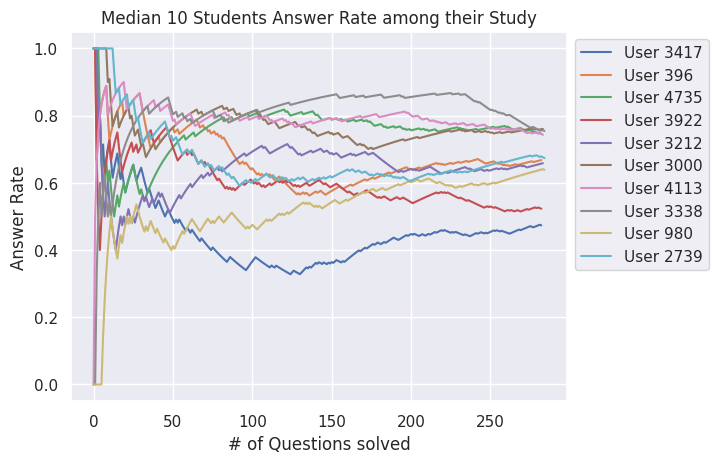

In [28]:
fig, ax = plt.subplots()
ax.set_title('Median 10 Students Answer Rate among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = df.groupby('userID').agg({'assessmentItemID': 'count'}).sort_values(by='assessmentItemID').index[7442//2-5:7442//2+5]
for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')
ax.legend(bbox_to_anchor=(1, 1))

정답률이 중앙값 부근인 10명의 학생들

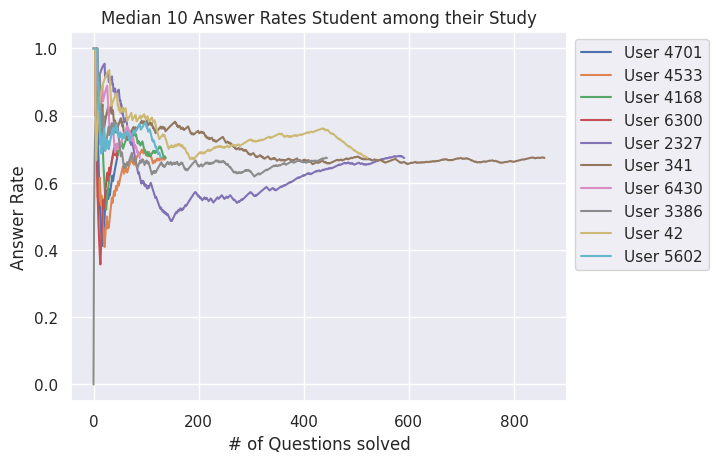

In [29]:
fig, ax = plt.subplots()
ax.set_title('Median 10 Answer Rates Student among their Study')
ax.set_xlabel('# of Questions solved')
ax.set_ylabel('Answer Rate')

samples = df.groupby('userID').agg({'answerCode': percentile}).sort_values(by='answerCode').index[7442//2-5:7442//2+5]
for idx in samples:
    cum_ans[cum_ans['userID'] == idx]['answerCode'].reset_index(drop=True).plot(ax=ax, label=f'User {idx}')
ax.legend(bbox_to_anchor=(1, 1))

Window_size 적용

In [30]:
def plot_rolled_answerrate(userID, ax, window_sizes=[70, 100, 120]):
    
    ax.set_title(f'Students Answer Rate among their Study - User {userID}')
    ax.set_xlabel('# of Questions solved')
    ax.set_ylabel('Answer Rate')

    cum_ans[cum_ans['userID'] == userID]['answerCode'].reset_index(drop=True).plot(
        ax=ax, label=f'Without Window', linewidth=3)

    for wdw_sz in window_sizes:    
        (df[df.userID == userID]['answerCode'].rolling(wdw_sz).sum().reset_index(drop=True) / wdw_sz).plot(
            ax=ax, label=f'Window size {wdw_sz}', alpha=0.8)

    ax.legend()

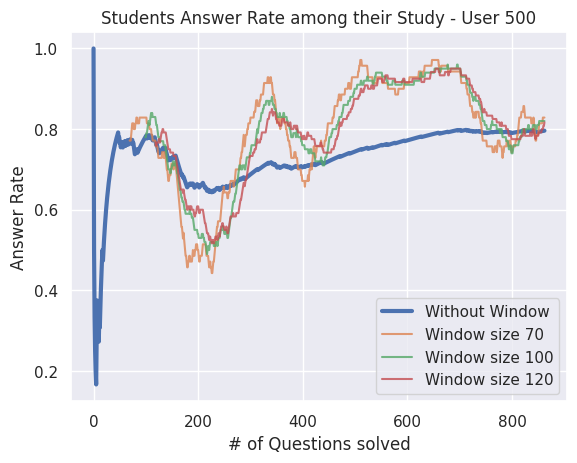

In [31]:
fig, ax = plt.subplots()
plot_rolled_answerrate(500, ax)

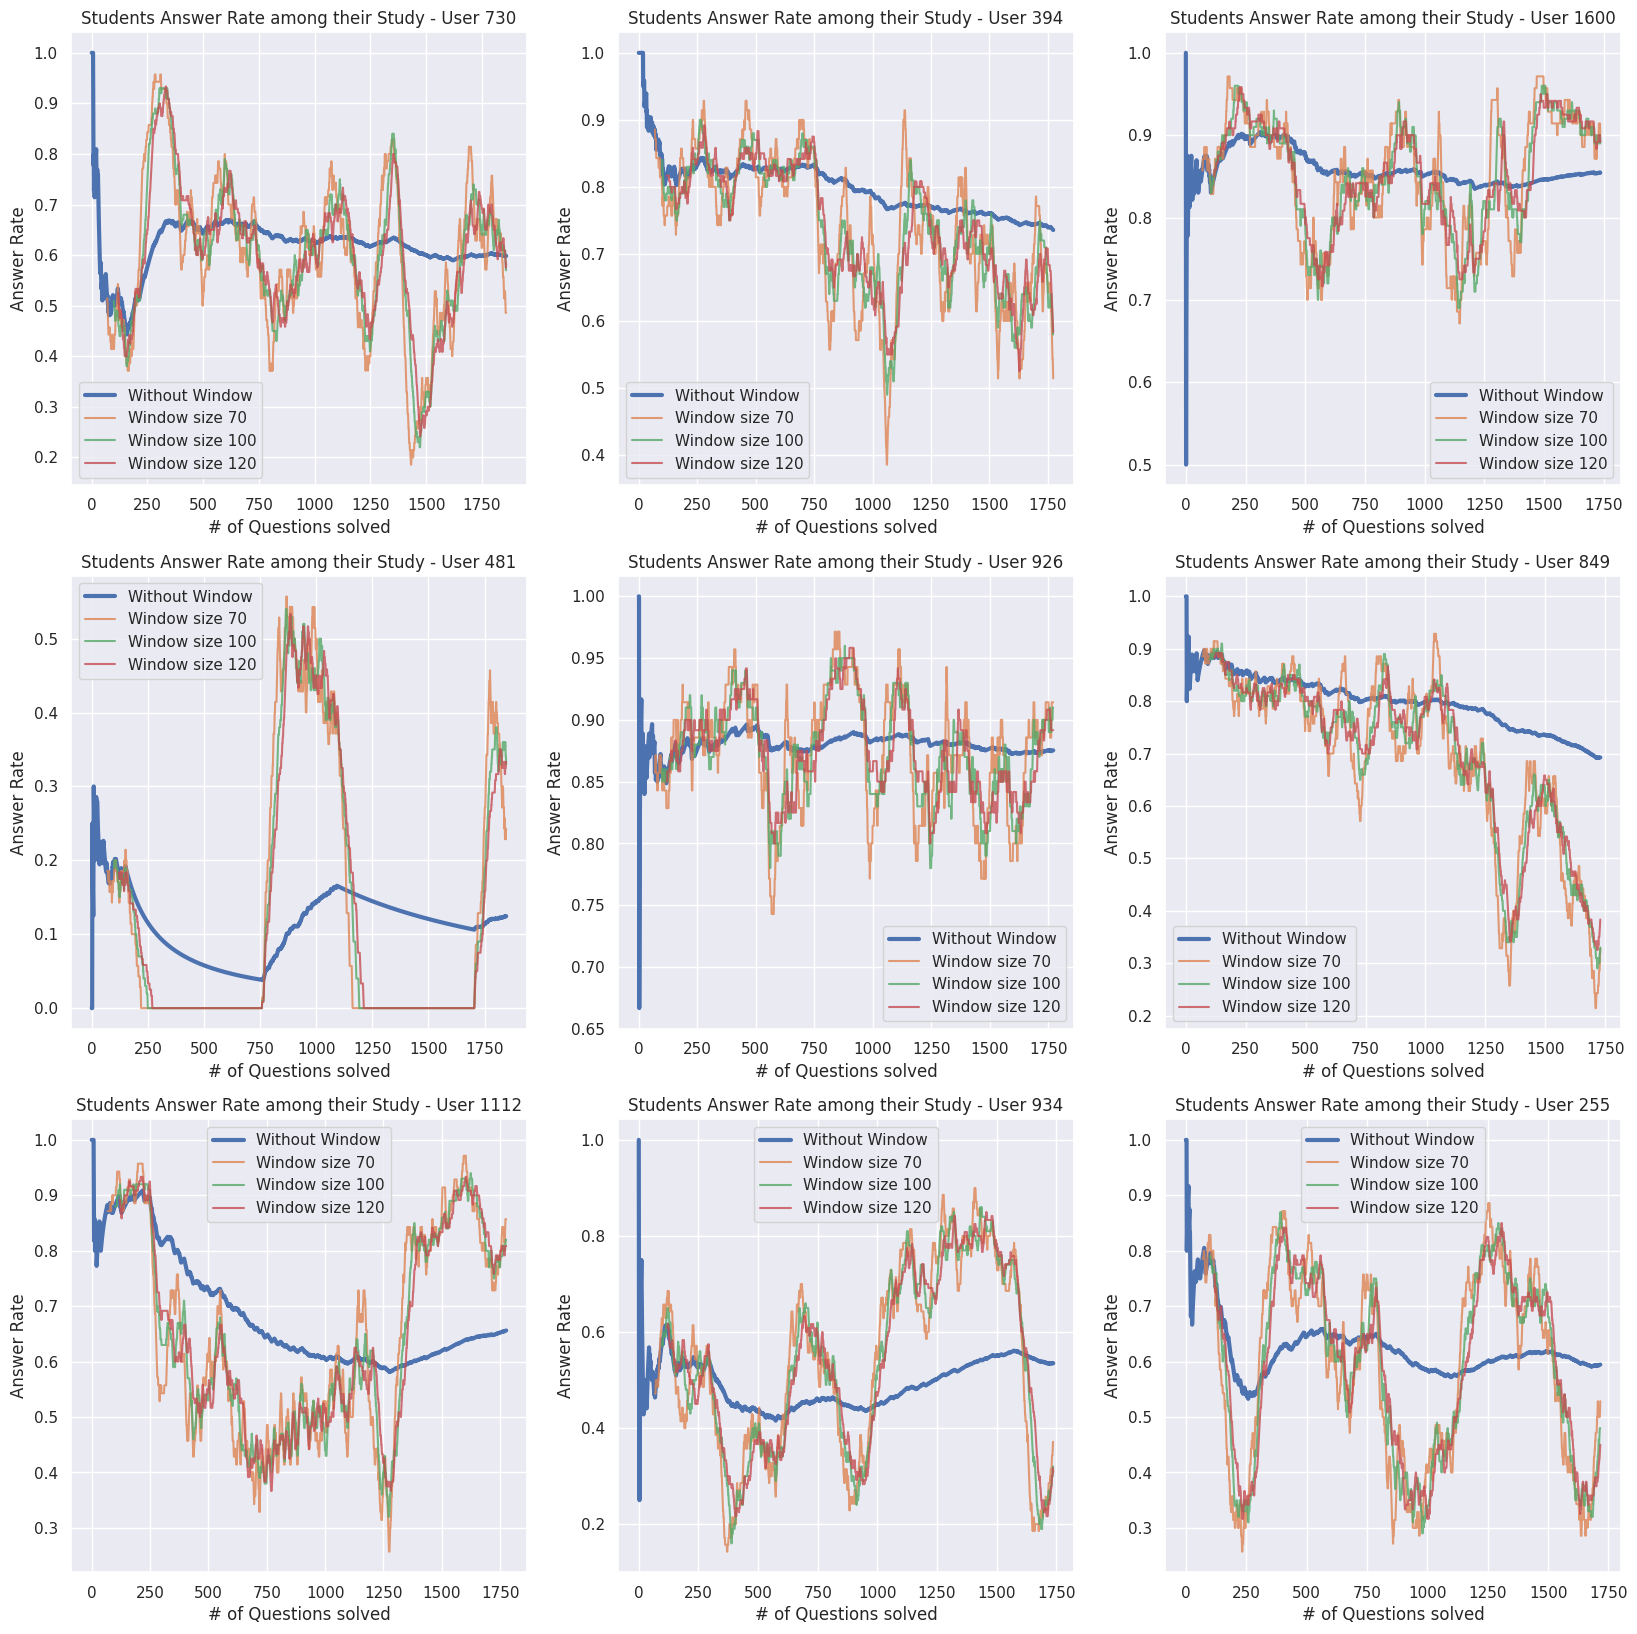

In [32]:
idx = df.groupby('userID').agg({'answerCode': 'count'}).sort_values(by='answerCode', ascending=False).iloc[:9].index
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
plt.title('Top 9 Students who solved the most problems')
for i, userID in enumerate(idx):
    
    r, c = i%3, i//3
    plot_rolled_answerrate(userID, axes[r, c])

### 문항을 푸는 데 걸린 시간과 정답률 사이의 관계는?

In [33]:
diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
diff = diff.fillna(pd.Timedelta(seconds=0))
diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

df['elapsed'] = diff

elapsed_answer = df.groupby('elapsed').agg({'answerCode': percentile, 'userID': 'count'})
elapsed_hist = elapsed_answer[elapsed_answer['userID'] > 100]

(-10.0, 650.0)

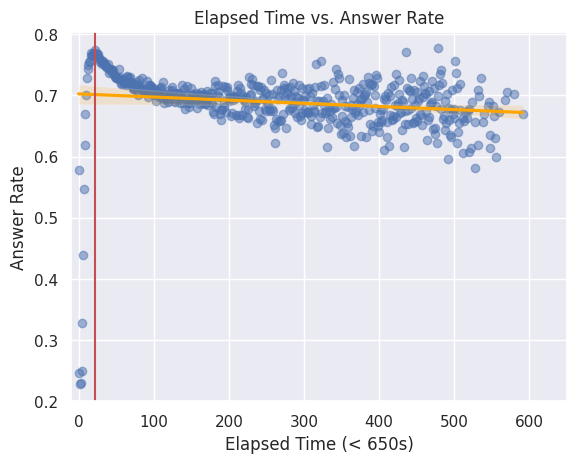

In [34]:
fig, ax = plt.subplots()
g = sns.regplot(x=elapsed_hist.index[:-1], y=elapsed_hist.answerCode.values[:-1],
            scatter_kws={'alpha':0.5}, line_kws={"color": "orange"}, ax=ax)
ax.set_title('Elapsed Time vs. Answer Rate')
ax.set_xlabel('Elapsed Time (< 650s)')
ax.set_ylabel('Answer Rate')
ax.axvline(22, color='r')
ax.set_xlim(-10, 650)

# 2. Daily Mission

### (a)
사실 위에서 그린 문항수-정답률 그래프는 큰 insight를 주지 못하는 것 같습니다. 같은 문항을 푼 학생들의 정답률은 당연히 상이하겠지만, 이 평균을 보는 것이 더 의미가 있을 것 같은데 아래처럼 보면 너무 점이 많아서 insight를 얻기 힘드네요.

그러면 이번엔 같은 문항수를 푼 학생들이 있다면, 그 학생들의 평균을 찍어서 그래프를 그려봅시다. 가령 9문항을 푼 학생이 10명이라면, 그 학생들의 평균이 찍히도록 말이죠! 아래와 같은 형태이면 좋을 것 같습니다.
- **x-axis**: 사용자가 푼 문항의 수
- **y-axis**: 정답률   
<br>

In [35]:
stu_groupby = df.groupby('userID').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_groupby.describe()

,assessmentItemID,answerCode
count,6698.000000,6698.000000
mean,338.397432,0.628909
std,321.331429,0.159639
min,9.000000,0.000000
25%,78.000000,0.527273
50%,231.500000,0.651757
75%,513.000000,0.751203
max,1860.000000,1.000000


In [38]:
meanAssementID_groupby = stu_groupby.groupby('assessmentItemID').mean()
meanAssementID_groupby['item_index'] = meanAssementID_groupby.index

(-50.0, 1900.0)

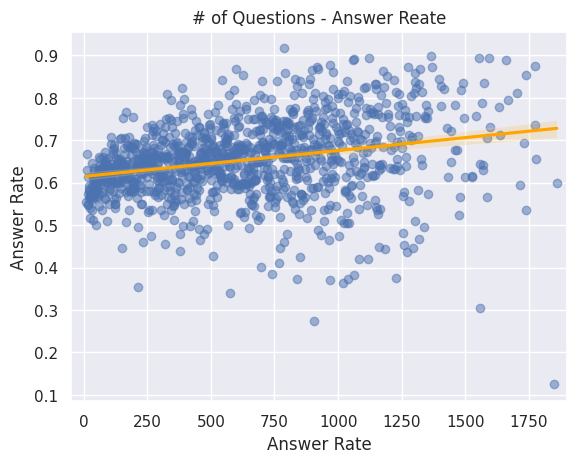

In [44]:
fig, ax = plt.subplots()
g = sns.regplot(data= meanAssementID_groupby, x= 'item_index', y='answerCode',
            scatter_kws={'alpha':0.5}, line_kws={"color": "orange"}, ax=ax)
ax.set_title('# of Questions - Answer Reate')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Answer Rate')
# ax.axvline(22, color='r')
ax.set_xlim(-50, 1900)

### (b)

그런데 위 그래프도... 사실 점이 너무 많습니다. 이것보다 더 줄이려면 단순히 같은 문항수를 푼 학생들끼리 평균을 집계하는 것이 아니라, 어느 정도 비슷한 문항을 푼 학생들을 전부 집계하면 좋을 것 같네요. 예를 들면 9 ~ 14문항을 푼 학생들을 묶어서 평균을 내는 것처럼요.   
`bins` 값을 주었을 때 bins 만큼 그래프에 점이 찍히도록, 예를 들어 bins=300이었다면 아래와 같이 300개의 bin을 만들어서 그래프가 그려지도록 해주세요 :)    


In [45]:
itemnum_ans = stu_groupby.groupby('assessmentItemID').mean()
bins = 300
itemnum_ans['bins'] = pd.cut(
    itemnum_ans.index,
    [i * (itemnum_ans.index.max() - itemnum_ans.index.min()) // bins for i in range(bins)]
)

itemnum_ans = itemnum_ans.groupby('bins').mean()
itemnum_ans['mid'] = list(map(lambda x: (x.left + x.right)//2, itemnum_ans.index))
itemnum_ans

/tmp/ipykernel_89224/125596665.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  itemnum_ans = itemnum_ans.groupby('bins').mean()


,answerCode,mid
bins,,
"(0, 6]",NaN,3
"(6, 12]",0.555556,9
"(12, 18]",0.596506,15
"(18, 24]",0.576610,21
"(24, 30]",0.555796,27
...,...,...
"(1813, 1820]",NaN,1816
"(1820, 1826]",NaN,1823
"(1826, 1832]",NaN,1829


Text(0, 0.5, 'Answer Rate')

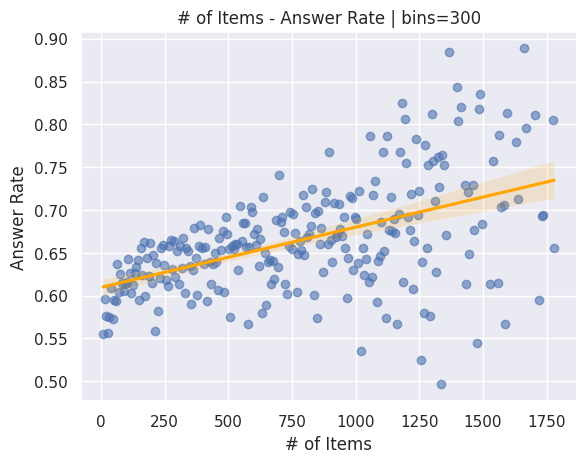

In [46]:
fig, ax = plt.subplots()
sns.regplot(data=itemnum_ans, x='mid', y='answerCode',
           line_kws={"color": "orange"}, scatter_kws={'alpha': 0.6}, ax=ax)

ax.set_title(f'# of Items - Answer Rate | bins={bins}')
ax.set_xlabel('# of Items')
ax.set_ylabel('Answer Rate')